# 3 layer LSTM WITHOUT batchnorm, dropout. 30 day input, 1 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/conv'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [6]:
num_input = 30
num_out = 1
train_X, train_y, dev_X, dev_y, test_X, test_y, y = utils.prepare_data(data, num_input, num_preds=num_out)

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (643, 30, 25)
train_y shape (643, 1)
dev_X shape (80, 30, 25)
dev_y shape (80, 1)
test_X shape (81, 30, 25)
test_y shape (81, 1)


In [8]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(
    CuDNNLSTM(
        128,
        input_shape=input_shape,
        return_sequences=True,
    )
)
model.add(Dropout(dropout_rate))

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(CuDNNLSTM(128))
model.add(Dropout(dropout_rate))

model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(num_out, activation="linear"))


opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 30, 128)           79360     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 30, 128)           132096    
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
__________

In [9]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 643 samples, validate on 80 samples
Epoch 1/200
643/643 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 0.0042
Epoch 2/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0149 - val_loss: 6.3098e-04
Epoch 3/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0083 - val_loss: 8.9978e-04
Epoch 4/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 3.7808e-04
Epoch 5/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 6/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 9.5597e-04
Epoch 7/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 3.5033e-04
Epoch 8/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 5.5206e-04
Epoch 9/200
643/643 [==============================] - 1s 1ms/st

643/643 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 1.0961e-04
Epoch 156/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 1.6817e-04
Epoch 157/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 5.4976e-04
Epoch 158/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 5.0699e-04
Epoch 159/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 2.4869e-04
Epoch 160/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 4.7288e-04
Epoch 161/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 1.7168e-04
Epoch 162/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 5.1725e-04
Epoch 163/200
643/643 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 2.1800e-04
Epoch 164/200
643/643 [============================

[Model] Predicting Sequences Multiple...


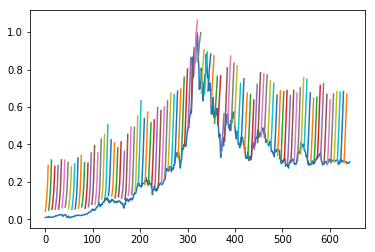

In [41]:
predicted_train = model_funcs.predict_sequences_multiple(model, train_X, num_input, 7)
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train, true_train, 7)

[Model] Predicting Sequences Multiple...


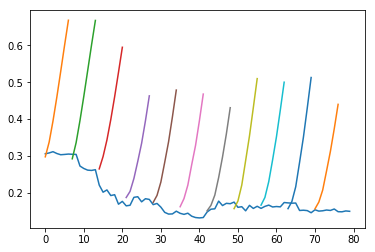

In [31]:
predicted_dev = model_funcs.predict_sequences_multiple(model, dev_X, num_input, 7)
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev, true_dev, 7)

[Model] Predicting Sequences Multiple...


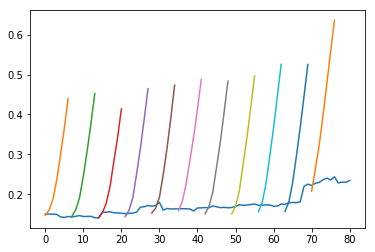

In [33]:
predicted_test = model_funcs.predict_sequences_multiple(model, test_X, num_input, 7)
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test, true_test, 7)

In [46]:
predicted_train = np.array(predicted_train).reshape(-1,1)
predicted_dev = np.array(predicted_dev).reshape(-1,1)
predicted_test = np.array(predicted_test).reshape(-1,1)

print("MSE Train:", mean_squared_error(predicted_train, true_train[:len(predicted_train)]))
print("MSE Dev:", mean_squared_error(predicted_dev, true_dev[:len(predicted_dev)]))
print("MSE Test:", mean_squared_error(predicted_test, true_test[:len(predicted_test)]))

MSE Train: 0.03624728996787885
MSE Dev: 0.03718744640659269
MSE Test: 0.029164791449866855


In [47]:
# print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
# print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
# print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

print("Acc Train:", utils.direction_accuracy(predicted_train, true_train[:len(predicted_train)]))
print("Acc Dev:", utils.direction_accuracy(predicted_dev, true_dev[:len(predicted_dev)]))
print("Acc Test:", utils.direction_accuracy(predicted_test, true_test[:len(predicted_test)]))

Acc Train: 0.539308176100629
Acc Dev: 0.5263157894736842
Acc Test: 0.6578947368421053


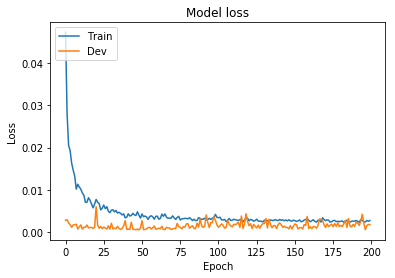

In [30]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()